# Credit Card Fraud Detection
#### A Case Study
***


The aim is to identify a fraudulent credit card transaction from a non-fraudulent one, and subsequently build a model to predict the same.
The dataset provided is for transactions made by credit cards in September 2013 by european cardholders, for a time period of two days.

From the source of this dataset, we have the information that there are over 2 lakh data points, out of which less than one percent is classified as fraud. It is a clear **Class Imbalance** scenario. As an initial thought, we will have to keep that in mind during our model building phase. Let's dive into it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import os
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
!pwd

/kaggle/working


In [3]:
#Change directory to where dataset is - not required on kaggle
#os.chdir("X:\\Datasets\creditcardfraud")

In [4]:
#Reading the dataset
master_df=pd.read_csv('../input/creditcardfraud/creditcard.csv')

In [5]:
#Keeping our original dataset safe :)
transaction_data = master_df.copy()

In [6]:
display(transaction_data.head())
print("Dimensions of the dataset are:", transaction_data.shape)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dimensions of the dataset are: (284807, 31)


In [7]:
#Data points for Fraudulent transactions
fraud = len(transaction_data[transaction_data["Class"]==1])
print("Total Fraud transactions are", fraud, ", which is") 
print(round(fraud/len(transaction_data) * 100, 2), "% of the dataset")

Total Fraud transactions are 492 , which is
0.17 % of the dataset


In [8]:
#Checking for null values (all values are numerical)
transaction_data.isnull().sum()

# We have no null values

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
#Let's look at the summary of the data
transaction_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


At first glance, we can easily see that features V1-28 have been transformed, as mentioned, using PCA. We can't really gather anything from them.<br>
Also, looks like 'Amount' might turn out to be a parameter to predict outliers(frauds), as there is a huge difference between Maximum amount (25691.16) and Mean amount (88.349619). Let's check.

In [10]:
#Let's convert the time variable into hours from seconds before moving forward

transaction_data['Time'] = transaction_data['Time']/3600

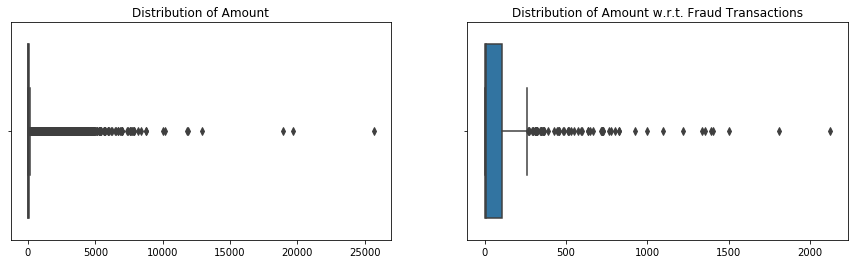

In [11]:
#Distribution of Amount
figure, a = plt.subplots(1, 2, figsize=(15, 4))
amount = transaction_data['Amount'].values

sns.boxplot(amount, ax = a[0])
a[0].set_title('Distribution of Amount')

fraud_df = transaction_data[transaction_data['Class']==1]
amount_fraud = fraud_df['Amount'].values

sns.boxplot(amount_fraud, ax = a[1])
a[1].set_title('Distribution of Amount w.r.t. Fraud Transactions')
#Keeping a similar scale as previous graph for comparison
#a[1].set_xlim([min(amount), max(amount)])
plt.show()

As we can see, the outliers in *fraud transactions* are not very significantly high, as compared to the whole dataset. So amount doesn't really look like a direct predictor. 

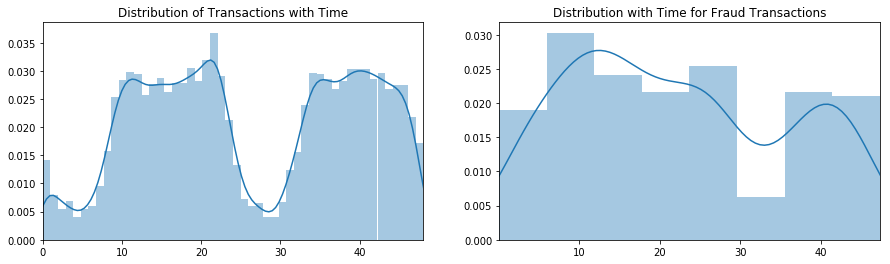

In [12]:
#Checking distribution with time

figure, a = plt.subplots(1, 2, figsize=(15, 4))
time = transaction_data['Time'].values

sns.distplot(time, ax = a[0])
a[0].set_title('Distribution of Transactions with Time')
a[0].set_xlim([min(time), max(time)])
#fraud_df_time = transaction_data[transaction_data['Class']==1]

time_fraud = fraud_df['Time'].values

sns.distplot(time_fraud, ax = a[1])
a[1].set_title('Distribution with Time for Fraud Transactions')
#Keeping a similar scale as previous graph for comparison
a[1].set_xlim([min(time_fraud), max(time_fraud)])
plt.show()

From this visualisation, we can see that there is not much difference in the trend with time as well. Though an interesting thing to note will be the higher number of fraud transactions near the 10th hour. The total transactions are higher around the 20th hour. But we can't say for sure if this assumption is believable as data points for fraud transactions are too less.

It follows from this, that our analysis will be severely affected by the huge class imbalance that we have observed. Even during model building, our model might tend to overfit the data, and we might see very high accuracy scores. Hence, we will have to keep in mind the following things:

- Dataset needs to be modified in a way, to provide some balance between both classes. We can generally do this through **Under Sampling or Over Sampling** the data.
- Whichever model we use for prediction, we will have to use appropriate metrics to check our model performance, as simple scores such as Accuracy can be very misleading. Best approach would be to use Precision-Recall scores as well as **Area Under Precision-Recall Curve.**

***

#### Let's go ahead with data manipulation.

In [13]:
#Scaling time and amount values, as all other predictors are already scaled through PCA
#Using min-max scaler for higher efficiency 

scaler = MinMaxScaler()
transaction_data['Time'] = scaler.fit_transform(transaction_data["Time"].values.reshape(-1,1))
transaction_data['Amount'] = scaler.fit_transform(transaction_data["Amount"].values.reshape(-1,1))

In [14]:
display(transaction_data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0


Now, coming to the first problem of class imbalance, let's go forward with a technique called SMOTE, or Synthetic Minority Oversampling Technique. As the name suggests, it is an oversampling technique which will increase the minority class data points in proportion to the majority class.<br>

It should be noted that we are not going with UnderSampling, as it poses the risk of losing out on important information. With SMOTE (oversampling), more information is available.

In [15]:
#Splitting into values and class labels 
target = 'Class'
labels = transaction_data[target]
values = transaction_data.copy()
values = values.drop('Class', axis =1 )
display(values.head())
print("Dataset dimension :", values.shape)
print("Labels dimension :", labels.shape)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724


Dataset dimension : (284807, 30)
Labels dimension : (284807,)


Before applying any sampling technique, it should be remembered that we are going to fit our model, using the *sampled training set*, but we will be predicting using only the *original test set*. So we will have to split the data into training and testing sets, before we can apply any sort of sampling.

Also, I wish to use SelectKBest algorithm, to use the best features for classification. But since as of now, there is a huge class imbalance, the same will be represented through SelectKBest. So I will use it, after oversampling my dataset.

In [16]:
# We can use Stratified Shuffle Split or StratifiedKFold
strat_split = StratifiedShuffleSplit(n_splits=10, random_state=42)
for train_index, test_index in strat_split.split(values, labels):
    values_train, values_test = values.iloc[train_index], values.iloc[test_index]
    labels_train, labels_test = labels.iloc[train_index], labels.iloc[test_index]
print("Percentage of Fraud Transactions in Training Set using Stratified Shuffle Split:", 
      round(labels_train.value_counts()[1]/len(labels_train)*100, 4), "%")

kfold_split = StratifiedKFold(n_splits=10, random_state=47)
for train_index, test_index in kfold_split.split(values, labels):
    values_train1, values_test1 = values.iloc[train_index], values.iloc[test_index]
    labels_train1, labels_test1 = labels.iloc[train_index], labels.iloc[test_index]
print("Percentage of Fraud Transactions in Training Set using Stratified KFold:", 
      round(labels_train1.value_counts()[1]/len(labels_train1)*100, 4), "%")


Percentage of Fraud Transactions in Training Set using Stratified Shuffle Split: 0.1728 %
Percentage of Fraud Transactions in Training Set using Stratified KFold: 0.1728 %


We are getting similar results with both. Basically, our class imbalance percentage is maintained in our training sets, for both the cases. We will go ahead with StratifiedShuffleSplit.<br>

Dimensions of Oversampled dataset is : (511766, 30)


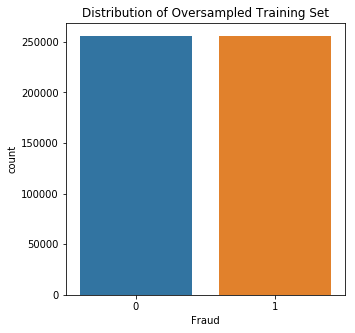

In [17]:
#Applying SMOTE on the training dataset
smote = SMOTE(sampling_strategy='minority', random_state=47)
os_values, os_labels = smote.fit_sample(values_train, labels_train)

os_values = pd.DataFrame(os_values)
os_labels = pd.DataFrame(os_labels)

plt.figure(figsize=(5, 5))
sns.countplot(data = os_labels, x = 0 )
plt.title("Distribution of Oversampled Training Set")
plt.xlabel("Fraud")


print("Dimensions of Oversampled dataset is :", os_values.shape)

Now, since our dataset is equally balanced, let's apply selectKbest for attaining the best features as per feature scores.<br> Note that we will be using SKB on the oversampled dataset, as that is the one which will be used to fit the model. Hence, transforming the complete dataset would be unneccesary.

In [18]:
#SelectKBest on our oversampled training dataset
os_values_skb = os_values.copy()
skb = SelectKBest(k=15)
os_values_skb = skb.fit_transform(os_values_skb, os_labels[0].ravel())
display(pd.DataFrame(os_values_skb).head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.380790,1.460168,0.515471,-0.980070,0.103284,-0.487704,0.292950,0.831434,-1.096086,-0.443396,-2.077925,1.551339,0.780154,-0.069862,0.096838
1,2.073777,-0.117676,-1.487208,0.180482,0.144397,-0.848272,0.074330,0.921508,-0.074776,-0.909714,-0.291464,0.700905,-0.262352,-0.441265,0.170300
2,-1.536340,1.208131,1.346005,-0.098262,-0.147758,-0.261898,0.052810,-0.327872,-0.231221,1.286872,0.717841,0.623768,0.500324,-0.552090,-0.051076
3,1.005790,-0.852530,0.673332,0.042750,-0.930858,0.424797,-0.678517,1.118410,-0.309838,0.022151,0.543723,-0.212666,0.371656,-0.353939,0.252997
4,1.303873,0.538389,-0.249810,1.016667,0.266583,-0.974172,0.585286,-0.346978,0.028289,-0.578289,0.423826,0.420161,-0.141157,-0.478183,-0.328568


In [19]:
# Getting feature scores from SelectKBest after fitting
feature_list = values.columns
unsorted_list = zip(feature_list, skb.scores_)

sorted_features = sorted(unsorted_list, key=lambda x: x[1], reverse=True)
print(len(sorted_features))
print("Feature Scores:\n")
pprint(sorted_features[:15])

30
Feature Scores:

[('V14', 695401.5633160885),
 ('V4', 529748.7509203275),
 ('V11', 482715.0595605994),
 ('V12', 444424.65101446427),
 ('V10', 347989.8052745692),
 ('V16', 269725.01223687216),
 ('V9', 256199.601567696),
 ('V3', 233339.84445053834),
 ('V17', 229324.54653325584),
 ('V2', 176291.53072087196),
 ('V7', 149597.19511518668),
 ('V18', 137352.2024742917),
 ('V6', 115768.7371066314),
 ('V1', 110785.46638877272),
 ('V5', 86144.5279419894)]


In [20]:
selected_features = [i[0] for i in sorted_features[:15]]
print(selected_features)
#Transforming test according to Feature Selection

#values_test = values_test[selected_features]
os_values_skb = os_values.copy()
display(values_test.head())

['V14', 'V4', 'V11', 'V12', 'V10', 'V16', 'V9', 'V3', 'V17', 'V2', 'V7', 'V18', 'V6', 'V1', 'V5']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
187452,0.738119,1.916118,-1.054471,-2.204962,-0.564104,0.342751,0.178114,0.033599,-0.242228,-0.746888,...,-0.180662,0.093706,0.643539,-0.342013,-0.273780,0.555610,0.106861,-0.031833,-0.045836,0.006462
110013,0.414614,0.957414,0.040111,0.351312,1.175282,-0.214718,-0.300366,0.225456,0.066156,-0.361456,...,-0.034730,-0.333800,-1.255362,0.197831,0.123161,0.063890,-0.843956,0.002473,0.032112,0.003697
70141,0.310935,-1.649279,1.263974,-1.050826,2.237991,-2.527889,-0.889940,-2.355254,0.854659,-1.281243,...,0.087406,0.679176,0.731907,0.333045,0.392505,-0.274197,0.802349,0.390809,0.112146,0.004377
15463,0.155383,-2.693420,2.337264,-0.303612,2.352796,0.091536,-0.544235,1.281668,-0.459579,0.769469,...,1.263153,-0.403418,0.522401,-0.136038,0.515889,-0.678903,0.004672,0.717001,0.307317,0.002190
72476,0.316699,0.683389,-0.940750,-0.032823,0.352668,-0.898172,-1.047873,0.440964,-0.293963,0.178112,...,0.533982,-0.045068,-0.877869,-0.160987,0.432490,0.041511,0.783159,-0.148393,0.058986,0.012417


Unfortunately, after testing SelectKBest, our predictions were getting only worse, so we will not be using SelectKBest. For model building purpose, all features will be used, as is.

***
#### Model Building
Let's now test this oversampled dataset on a basic Logistic Regression model, as this is a binary classification problem

In [21]:
#Using this Oversampled data to fit a Logistic Regression model
logr = LogisticRegression().fit(os_values_skb, os_labels[0].ravel())

#Predicting on original test set
predictions = logr.predict(values_test)

print("Accuracy Score: ", round(accuracy_score(labels_test, predictions)*100, 2), '%')
print(classification_report(labels_test, predictions, target_names=["No Fraud", "Fraud"]))


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score:  97.32 %
              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     28432
       Fraud       0.06      0.92      0.11        49

    accuracy                           0.97     28481
   macro avg       0.53      0.95      0.55     28481
weighted avg       1.00      0.97      0.98     28481



(0.0, 1.1)

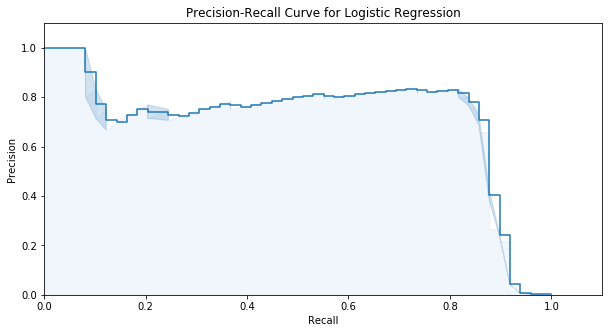

In [22]:
#Computing major metrics
y_score = logr.decision_function(values_test)
precision, recall, _ = precision_recall_curve(labels_test, y_score)
fig = plt.figure(figsize=(10,5))
sns.lineplot(recall, precision, drawstyle='steps-post')
plt.fill_between(recall, precision, alpha=0.1, color='#78a2e2')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.1])


As we can see, our Logistic Regression model, is not proving to be as good as model which the accuracy is suggesting. The precision score is too low. The Precision-Recall curve though, depicts a different story. The documentation states the following:

> <font color="#686a6d">The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)"</font>

The area under the P-R curve seems to depict that our model is working moderately well. We could expect a better performance though, since we have not even tuned this model as of now. We will have to tune our model with various parameters, for achieving a better performance. Before we do that, let's look at the performance with some other models.

In [23]:
t0 = time.time()

DT = DecisionTreeClassifier()
y_pred_DT = DT.fit(os_values_skb, os_labels[0].ravel()).predict(values_test)

t1 = time.time()
print("Fitting Decision Tree model took", t1-t0, "secs.")
print("."*10)
ada = AdaBoostClassifier()
y_pred_ada = ada.fit(os_values_skb, os_labels[0].ravel()).predict(values_test)

t2 = time.time()
print("Fitting Adaboost model took", t2-t1, "secs.")
print("."*10)
xgb = GradientBoostingClassifier()
y_pred_xgb = xgb.fit(os_values_skb, os_labels[0].ravel()).predict(values_test)

t3 = time.time()
print("Fitting XGBoost model took", t3-t2, "secs.")
print("."*10)

AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [24]:
# Precision, Recall, and actual prediction numbers
print("Accuracy Score for DT: ", round(accuracy_score(labels_test, y_pred_DT)*100, 2), '%')
print(classification_report(labels_test, y_pred_DT))
print("-" * 40)
print("Accuracy Score for AdaBoost: ", round(accuracy_score(labels_test, y_pred_ada)*100, 2), '%')
print(classification_report(labels_test, y_pred_ada))
print("-" * 40)
print("Accuracy Score for XGB: ", round(accuracy_score(labels_test, y_pred_xgb)*100, 2), '%')
print(classification_report(labels_test, y_pred_xgb))

NameError: name 'y_pred_DT' is not defined

We are achieving similar results from this. Let's move on to tuning our parameters for our models, using GridSearchCV.
***

#### Tuning Our Models

We will be tuning our basic Logistic Regression model, using various parameters, to obtain a better performance.

In [25]:
#Trying below three models:
# Logistic Regression Classifier
def tune_LogR():
    print("------------------ Using Logistic Regression --------------------")
    clf = LogisticRegression()
    param_grid = {
        'clf__penalty': ['l1', 'l2'],
        'clf__C' : [1.0, 10.0, 25.0, 50.0, 100.0, 500.0, 1000.0],
        'clf__solver' : ['liblinear']
    }

    return clf, param_grid

In [26]:
# Create pipeline
clf, params = tune_LogR()
estimators = [('clf', clf)]
pipe = Pipeline(estimators)

# Create GridSearchCV Instance
grid = GridSearchCV(pipe, params)
grid.fit(os_values_skb, os_labels[0].ravel())

# Final classifier
clf = grid.best_estimator_

print('\n=> Chosen parameters :')
print(grid.best_params_)

predictions = clf.predict(values_test)
print("Accuracy Score: ", round(accuracy_score(labels_test, predictions)*100, 2), '%')
print("Classification Report:\n", classification_report(labels_test, predictions, target_names = ['Non-Fraud', 'Fraud']))

------------------ Using Logistic Regression --------------------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



=> Chosen parameters :
{'clf__C': 50.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Accuracy Score:  97.35 %
Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.99     28432
       Fraud       0.06      0.92      0.11        49

    accuracy                           0.97     28481
   macro avg       0.53      0.95      0.55     28481
weighted avg       1.00      0.97      0.99     28481



(0.0, 1.1)

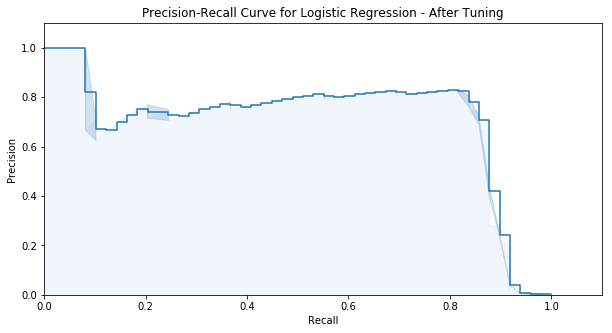

In [27]:
#Plotting the P-R curve for this tuned model
y_score = clf.decision_function(values_test)
precision, recall, _ = precision_recall_curve(labels_test, y_score)
fig = plt.figure(figsize=(10,5))
sns.lineplot(recall, precision, drawstyle='steps-post')
plt.fill_between(recall, precision, alpha=0.1, color='#78a2e2')
plt.title('Precision-Recall Curve for Logistic Regression - After Tuning')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.1])

In [28]:
#Plotting confusion matrix for this
tn, fp, fn, tp = confusion_matrix(labels_test, predictions).ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print('False Negatives:', fn)
print('True Positives:', tp)

True Negatives: 27680
False Positives: 752
False Negatives: 4
True Positives: 45


Let's test out our model's performance on an balanced dataset, for validation purposes.
We will split the data with a ratio of 70:30, keeping the percentage equal, as in using the oversampled dataset.

In [29]:
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=1)
for train_index, test_index in splitter.split(os_values, os_labels):
    _, os_values_test = os_values.iloc[train_index], os_values.iloc[test_index]
    _, os_labels_test = os_labels.iloc[train_index], os_labels.iloc[test_index]

In [30]:
predictions = clf.predict(os_values_test)
print("Accuracy Score: ", round(accuracy_score(os_labels_test, predictions)*100, 2), '%')
print("Classification Report:\n", classification_report(os_labels_test, predictions, target_names = ['Non-Fraud', 'Fraud']))

Accuracy Score:  94.65 %
Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.92      0.97      0.95     76765
       Fraud       0.97      0.92      0.95     76765

    accuracy                           0.95    153530
   macro avg       0.95      0.95      0.95    153530
weighted avg       0.95      0.95      0.95    153530



As is expected, we are getting amazing scores all over for this, as we have a balanced dataset, plus the model has been trained on it before.

***

### Summary

In conclusion, we have understood that this dataset has a huge class imbalance, that will definitely affect our analysis as well as model building approach. We have to keep in mind some important points, which are stated below:

- The relationships between our target variable 'Class' and our predictor variables, is difficult to estimate if we just look at the original dataset. It is highly skewed.
- To establish a clear understanding, we need to remove the class imbalance present in our dataset. We have used SMOTE as an oversampling technique for the minority class. We have not gone with undersampling as it may lead to information loss.
- Since this is a binary classification problem, we have chosen Logistic Regression as our model. After oversampling and tuning our model, we have achieved an accuracy of **97.34%**. Our main metric, **Area Under the Precision Recall Curve**, seems to show that model performance is moderate. We have high recall scores, but lower precision scores.
- Testing it on a balanced dataset, we have seen that both precision and recall prove to be very high.



Our main concern, is to point out if a transaction can be safely classified as fraud or not. This model might not be highly accurate in predicting frauds, but at the same time the number of correctly predicted 'Non-Fraud' Transactions is a positive point. We don't want actual, genuine transactions to be classified as Fraud. The case presented in this study is definitely a real world scenario, where the number of fake transactions would be quite low, when compared to genuine transactions.

Lastly, as part of future additions to this study, I would like to go ahead with in depth analysis of the PCA scaled features provided to us, through Hypothesis testing. It might lead to some idea of how they are affecting the target class. Also, using unsupervised learning techniques such as K-Means Clustering, on the oversampled data, might prove to be beneficial, as SMOTE works on the principle of nearest neighbours as well.